In [1]:
# Importing libraries
import os
import glob
import re
import nltk
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict

In [2]:
# download the IMDB large movie review corpus from the class webpage to a file location on your computer

PATH_TO_DATA = '../large_movie_review_dataset'  # set this variable to point to the location of the IMDB corpus on your computer
POS_LABEL = 'pos'
NEG_LABEL = 'neg'
TRAIN_DIR = os.path.join(PATH_TO_DATA, "train")
TEST_DIR = os.path.join(PATH_TO_DATA, "test")

for label in [POS_LABEL, NEG_LABEL]:
    if len(os.listdir(TRAIN_DIR + "/" + label)) == 12500:
        print "Great! You have 12500 {} reviews in {}".format(label, TRAIN_DIR + "/" + label)
    else:
        print "Oh no! Something is wrong. Check your code which loads the reviews"

Great! You have 12500 pos reviews in ../large_movie_review_dataset/train/pos
Great! You have 12500 neg reviews in ../large_movie_review_dataset/train/neg


In [3]:
def tokenize_doc_and_more(doc):
    bow = defaultdict(float)
    
    # Converting into lower case text
    doc_lower = doc.lower() 
    
    # removing pucntuations ("..", ".", ",")
    doc_wo_punc = re.sub(r'(\.+$|\?+$|\,|\'|\.{2,}|<br *(/>)?)|-',"",doc_lower)
    #doc_wo_punc = re.sub(r"[^A-Za-z0-9 ]+","", doc_lower)
    # removing two spaces 
    text_with_one_space = re.sub(r'[ ]{2,}'," ", doc_wo_punc).split()
    
    # removing stop words like "and", "the"
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in text_with_one_space if not w in stop_words]
    return filtered_sentence

In [4]:
print tokenize_doc_and_more("I was looking forward to The Guardian, but when I walked into the theater I wasn't really in the mood for it at that particular time. It's kind of like the Olive Garden - I like it, but I have to be in the right mindset to thoroughly enjoy it.<br /><br />I'm not exactly sure what was dampening my spirit")

['looking', 'forward', 'guardian', 'walked', 'theater', 'wasnt', 'really', 'mood', 'particular', 'time.', 'kind', 'like', 'olive', 'garden', 'like', 'right', 'mindset', 'thoroughly', 'enjoy', 'it.im', 'exactly', 'sure', 'dampening', 'spirit']


In [5]:
# Reading dataset and making list of list for positive and negative training examples.
positiveSentence = []
negativeSentence = []
numberofWords = []
for label in [POS_LABEL, NEG_LABEL]:
    for directory in [TRAIN_DIR, TEST_DIR]:
        for fn in glob.glob(directory + "/" + label + "/*txt"):
            ## Implement me!
            temp = tokenize_doc_and_more(open(fn).read())
            numberofWords.append(len(temp))
            if label == POS_LABEL:
                positiveSentence.append(temp)
            else:
                negativeSentence.append(temp)
                

In [6]:
#Check the loaded data in the positive and negative sentence
print "The number of positive examples " + str(len(positiveSentence))
print "The number of negative examples " + str(len(negativeSentence))

The number of positive examples 25000
The number of negative examples 25000


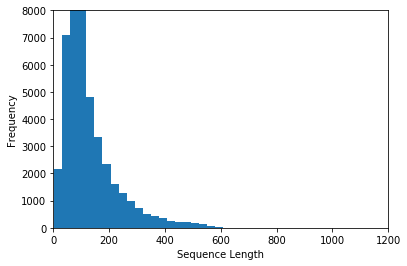

In [7]:
# Printing the number of words in all the sentences
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numberofWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

# Maximum length of words is about 600, but most sentence are covered in 250 words.


In [8]:
maxSeqLength = 250
batchSize = 1
numDimensions = 50
numFiles= 50000

In [9]:
# Loading the word vector 

import numpy as np
filename = 'glove.6B.50d.txt'
def loadGloVe(filename):
    vocab = []
    embd = []
    file = open(filename,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embd

# Glove Vector location
fileName = "../glove.6B/glove.6B.50d.txt"
wordList, wordVector = loadGloVe(fileName)


Loaded GloVe!


In [32]:
wordVector = np.load('wordVectors.npy')

In [33]:
# Number of words in the the word vector 
print len(list(wordVector))

400000


In [11]:
firstfile = np.zeros((maxSeqLength), dtype="int32")
indexCounter = 0
for word in positiveSentence[0]:
    try:
        firstfile[indexCounter] = wordList.index(word)
    except:
        firstfile[indexCounter] = 399999
    indexCounter += 1

# Id Matrix Commented because of computation of this code

ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
for sentence in positiveSentence:
    indexCounter = 0 
    for word in sentence:
        try:
            ids[fileCounter][indexCounter] = wordList.index(word)
        except ValueError:
            ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
        indexCounter = indexCounter + 1
        if indexCounter >= maxSeqLength:
            break
    fileCounter = fileCounter + 1 

for sentence in negativeSentence:
    indexCounter = 0 
    for word in sentence:
        try:
            ids[fileCounter][indexCounter] = wordList.index(word)
        except ValueError:
            ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
        indexCounter = indexCounter + 1
        if indexCounter >= maxSeqLength:
            break
    fileCounter = fileCounter + 1
np.save('idsMatrix', ids)

In [15]:
#Loading the id matrix
ids = np.load("idsMatrix.npy")

In [40]:
idsTensor = tf.constant(ids[0])
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVector,ids[0]).eval())

TypeError: List of Tensors when single Tensor expected